In [1]:
# Install the deepdow package.
!pip install deepdow

In [2]:
# Load necessary libraries
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, CumulativeReturn, Alpha, LargestWeight
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import prices_to_returns, raw_to_Xy
from deepdow.nn import BachelierNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random
import sys

from collections import deque
import matplotlib.pylab as plt

import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# List of 20 stocks chosen for the experiment.
stocks = ['GOOG', 'MSFT', 'TSLA', 'C', 'COST', 'WMT', 'AMZN', 'NVDA', 'AMD', 'META',
          'JPM', 'XOM', 'MRO', 'JNJ', 'PG', 'PFE', 'LLY', 'UNH', 'T', 'MCD']


In [4]:
# Download the stock data throughout the specified time period.
raw_df = yf.download(stocks, start="2012-05-18", end="2023-12-31", group_by='ticker')

# Check if there are any missing data.
raw_df.isnull().values.any()

[*********************100%%**********************]  20 of 20 completed


False

In [5]:
# If there are any non-positive data, make them positive.
if not np.all(raw_df > 0):
  raw_df[raw_df <= 0] = 1
np.all(raw_df > 0)

True

In [6]:
n_timesteps = len(raw_df)

# List the indicators to be used. For simplicity, we only used the historical daily closing prices.
included_indicators = ['Close']
# included_indicators = ['Close', 'High', 'Low', 'Open','Volume']

# Specify the lookback, gap, horizon lengths as frameworked in DeepDow. For simplicity, we took gap=0 throughout our experiments.
lookback, gap, horizon = 50, 0, 20  # WARNING: During validation and test, these values should be the same ones as the model was trained on!

# Obtain the features from the data.
X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_assets=stocks,
                                                      included_indicators = included_indicators,
                                                      use_log=False)

n_assets = len(asset_names)
n_channels = len(indicators)
n_samples =  n_timesteps - lookback - horizon - gap + 1

In [7]:
N = 2035 # N is manually calculated to ensure
         # timestamps[2035-lookback] corresponds to middle of covid 03/06/2020

# Set the split indices for train-validation-test split.
split_ix = N - lookback
test_split_ix = N + (n_samples-N)//2

# Calculate the list of indices for train,validation,test datasets.
# To prevent data leakage, we have lookback-many gap between the datasets.
indices_train = list(range(split_ix))
indices_val = list(range(split_ix + lookback, test_split_ix - lookback))
indices_test = list(range(test_split_ix, n_samples))

print('Train range: {}:{}\nValidation range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                                              indices_val[0],indices_val[-1],
                                                                              indices_test[0], indices_test[-1]))

Train range: 0:1984
Validation range: 2035:2393
Test range: 2444:2853


In [8]:
# Calculate mean and standard deviation of the train dataset for normalization.
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [0.00075074], std: [0.01798476]


In [9]:
# Move the dataset to RAM for training and evaluation.
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names, transform=Scale(means, stds))

In [10]:
# Construct the dataloaders for training, validation and test.
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_val = RigidDataLoader(dataset,
                                  indices=indices_val,
                                  batch_size=32)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

In [11]:
# The model architectures we trained.

class GreatNet(torch.nn.Module):
    def __init__(self, n_input, node_list, n_output, p=0.5):
        super().__init__()

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.input_layer = torch.nn.Linear(n_input, node_list[0], bias=True)
        self.hidden_layers = nn.ModuleList()
        if node_list:
          for i in range(len(node_list)-1):
            self.hidden_layers.append(torch.nn.Linear(node_list[i], node_list[i+1], bias=True))

        self.output_layer = torch.nn.Linear(node_list[-1], n_output, bias=True)

    def forward(self, x):
        # n_samples, _ = x.shape
        # x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
          x = F.relu(layer(x))
        x = self.output_layer(x)

        return x


class AssetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(AssetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)#.to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)#.to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc(out[:, -1, :]))
        return out

class LSTMNet(torch.nn.Module, Benchmark):
  def __init__(self, n_assets, n_channels, hidden_size, output_size, num_layers = 1, p_dropout=0.5, node_list = []):
        super().__init__()
        self.n_assets = n_assets
        self.n_channels = n_channels
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstms = nn.ModuleList()
        for _ in range(n_assets):
          self.lstms.append(AssetLSTM(n_channels, hidden_size, num_layers, output_size, dropout = p_dropout))
        if node_list:
          self.fc = GreatNet(output_size*n_assets, node_list, n_assets, p=0.5)
        else:
          self.fc = nn.Linear(output_size * n_assets, n_assets)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
  def forward(self, x):
        outputs = []
        for i in range(self.n_assets):
            # print(x.shape)
            # print(x[:, :, :,i].shape)
            # print(x[:, :, :,i].permute(0,2,1).shape)
            # print(self.lstms[i](x[:, :, :,i].permute(0,2,1)).shape)
            out = self.lstms[i](x[:, :, :,i].permute(0,2,1))
            outputs.append(out)
        output_concat = torch.cat(outputs, dim=1)
        # print(output_concat.shape)
        out = self.fc(output_concat)
        # print(out.shape)
        weights = self.allocate_layer(out, self.temperature)
        return weights

class SingleLSTMNet(torch.nn.Module, Benchmark):
  def __init__(self, n_assets, n_channels, hidden_size, output_size, num_layers = 1, p_dropout=0.5, node_list = []):
        super().__init__()
        self.n_assets = n_assets
        self.n_channels = n_channels
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = AssetLSTM(n_channels, hidden_size, num_layers, output_size, dropout = p_dropout)

        if node_list:
          self.fc = GreatNet(output_size*n_assets, node_list, n_assets, p=0.5)
        else:
          self.fc = nn.Linear(output_size * n_assets, n_assets)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
  def forward(self, x):
        outputs = []
        for i in range(self.n_assets):
            out = self.lstm(x[:, :, :,i].permute(0,2,1))
            outputs.append(out)
        output_concat = torch.cat(outputs, dim=1)
        # print(output_concat.shape)
        # print(self.output_size*self.n_assets)
        out = self.fc(output_concat)
        # print(out.shape)
        weights = self.allocate_layer(out, self.temperature)
        return weights

class FullyConnectedNet(torch.nn.Module,Benchmark):
  def __init__(self, n_assets, lookback, n_channels, node_list = []):
    super(FullyConnectedNet,self).__init__()
    self.n_assets = n_assets
    self.lookback = lookback
    self.n_channels = n_channels
    self.node_list = node_list
    self.flatten = nn.Flatten()
    if node_list:
        self.fc = GreatNet(self.n_assets*self.lookback*self.n_channels, self.node_list, self.n_assets, p=0.5)
    else:
        self.fc = nn.Linear(self.n_assets*self.lookback*self.n_channels, self.n_assets)
    self.allocate_layer = SoftmaxAllocator(temperature=None)
    self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
  def forward(self, x):
      # print(output_concat.shape)
      # print(self.output_size*self.n_assets)
      out = self.fc(self.flatten(x))
      # print(out.shape)
      weights = self.allocate_layer(out, self.temperature)
      return weights


In [12]:
# Here the hyperparameters for different models can be specified.

hidden_layers = [200,100]

# network = FullyConnectedNet(n_assets, lookback, n_channels, node_list = hidden_layers)
# network = BachelierNet(n_channels, n_assets) # An LSTM network in the package. Alternatively, comment this and uncomment GreatNet.
# network = SingleLSTMNet(n_assets, n_channels, hidden_size = 30, output_size = 30, num_layers = 7, p_dropout=0.5, node_list = hidden_layers)
network = LSTMNet(n_assets, n_channels,hidden_size = 40, output_size = 30, num_layers = 2, p_dropout=0.5, node_list = hidden_layers)
print(network)

LSTMNet(
  (lstms): ModuleList(
    (0-19): 20 x AssetLSTM(
      (lstm): LSTM(1, 40, num_layers=2, batch_first=True, dropout=0.5)
      (fc): Linear(in_features=40, out_features=30, bias=True)
    )
  )
  (fc): GreatNet(
    (dropout_layer): Dropout(p=0.5, inplace=False)
    (input_layer): Linear(in_features=600, out_features=200, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=200, out_features=100, bias=True)
    )
    (output_layer): Linear(in_features=100, out_features=20, bias=True)
  )
  (allocate_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [13]:
network = network.train() # it is the default, however, just to make the distinction clear

# We chose a combination of cumulative return and Sharpe Ratio (a measure of risk in portfolios) as our loss function.
loss = CumulativeReturn() + SharpeRatio()
# One can use LargestWeight() or SquaredWeights() for regularization on computed weights. See deepdow.losses for other Loss functions.

In [14]:
# deepdow implements a simple wrapper Run that implements the training loop and a minimal callback framework.
# EarlyStoppingCallback makes the training stop if the validation loss do not improve for the 'patience' amount of training epochs.
# ModelCheckpointCallback saves the model weights whenever the validation loss reaches a minimum throughout the training.
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'val': dataloader_val},
          optimizer=torch.optim.Adam(network.parameters(), lr = 0.001, amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='val',
                                           patience=25),
                     ModelCheckpointCallback(folder_path="/content/Models/",
                                             dataloader_name = 'val',
                                             metric_name = 'loss',
                                             verbose=True)])

In [15]:
# Run the training loop for the specified number of epochs.
history = run.launch(5)

Epoch 0: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=-0.18653, val_loss=-0.22184]


Checkpointed /content/Models/model_00__-0.2218.pth


Epoch 2: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s, loss=-0.18695, val_loss=-0.22920]


Checkpointed /content/Models/model_02__-0.2292.pth


Epoch 4: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s, loss=-0.20666, val_loss=-0.19781]


<Axes: xlabel='epoch'>

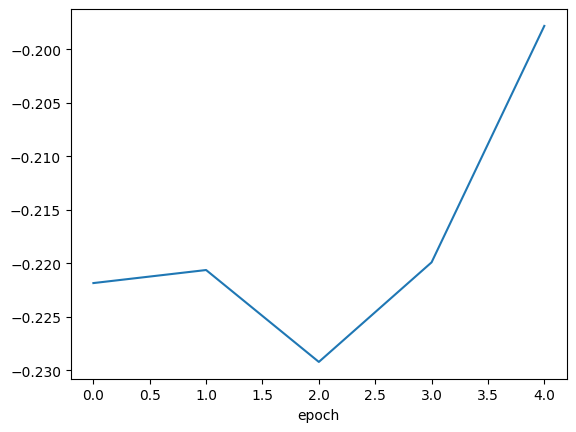

In [16]:
# Plot the loss on the validation set to prevent overfitting.

per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

per_epoch_results.mean()['val']['loss']['network'].plot()

In [17]:
# Utility function to compute portfolio returns from the weight allocations generated by the model.
def duplicate_rows(tensor, n, is_val = True):
    # Get the dimensions of the input tensor
    rows, cols = tensor.shape

    # Create an empty tensor to store the duplicated rows
    duplicated_tensor = torch.empty(rows * n, cols, dtype=tensor.dtype)

    # Duplicate each row n times
    for i in range(rows):
        duplicated_tensor[i*n:(i+1)*n, :] = tensor[i, :].unsqueeze(0).repeat(n, 1)
    if is_val:
      return duplicated_tensor[:len(indices_val),:]
    else:
      return duplicated_tensor[:len(indices_test),:]

In [18]:
# Filepath of the saved weights.
myModel = torch.load('/content/Models/18_SingleLSTMNet.pth')
# Uncomment the following to use the previously trained model.
# myModel = network

myModel = myModel.eval()

# Get X,Y features and timestamps for the validation dataset.
X = torch.empty(0)
Y = torch.empty(0)
val_timestamps = []
for i in range(indices_val[0], indices_val[-1]+1):
  X_sample, Y_sample, timestamps_sample, _ = dataset.__getitem__(i)
  X = torch.cat((X,X_sample.unsqueeze(0)), dim = 0)
  Y = torch.cat((Y,Y_sample.unsqueeze(0)), dim = 0)
  val_timestamps.append(timestamps_sample)
X = X.float()

# Get the daily returns using Y.
rets = Y[:,0,0,:] + 1

# Calculate the weight allocations by inputting X to the model.
with torch.no_grad():
  weights = duplicate_rows(myModel(X),gap+horizon)
weights.shape

# Obtain weights for equal hold portfolio.
n_eq_weights = torch.ones([len(indices_val),n_assets])/n_assets
n_eq_weights.shape

# Obtain weights for the one-asset portfolios. We used TSLA and NVDA as they are the top performers during validation period.
TSLA_weights = torch.zeros([len(indices_val),n_assets])
TSLA_weights[:,asset_names.index('TSLA')] = 1 # 16

NVDA_weights = torch.zeros([len(indices_val),n_assets])
NVDA_weights[:,asset_names.index('NVDA')] = 1 # 12

# Change the dimensions of returns and weights so portfolio returns can be performed using matrix multiplication.
rets = rets.unsqueeze(1)

weights = weights.unsqueeze(2)
n_eq_weights = n_eq_weights.unsqueeze(2)
TSLA_weights = TSLA_weights.unsqueeze(2)
NVDA_weights = NVDA_weights.unsqueeze(2)

portfolio_return = torch.bmm(rets.double(), weights.double()).squeeze(1).squeeze(1)
n_eq_return = torch.bmm(rets.double(), n_eq_weights.double()).squeeze(1).squeeze(1)
TSLA_return = torch.bmm(rets.double(), TSLA_weights.double()).squeeze(1).squeeze(1)
NVDA_return = torch.bmm(rets.double(), NVDA_weights.double()).squeeze(1).squeeze(1)

portfolio_return = torch.cumprod(portfolio_return, dim=0)
n_eq_return = torch.cumprod(n_eq_return, dim=0)
TSLA_return = torch.cumprod(TSLA_return, dim=0)
NVDA_return = torch.cumprod(NVDA_return, dim=0)

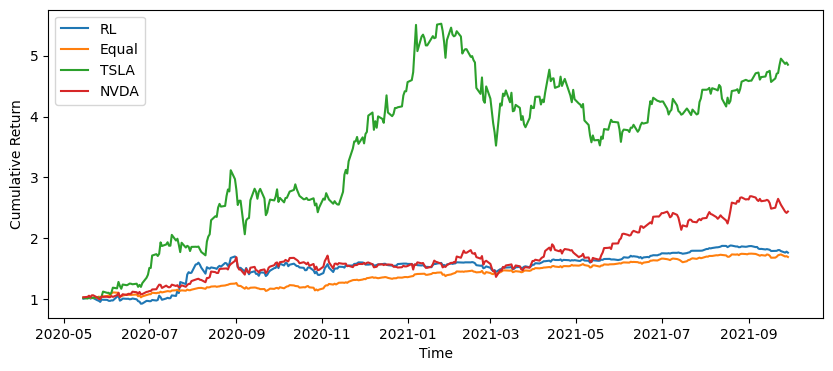

In [19]:
# Plot the portfolio cumulative return during validation period.
plt.figure(figsize=(10,4))

plt.plot(val_timestamps,portfolio_return, label = 'RL')
plt.plot(val_timestamps,n_eq_return, label = 'Equal')
plt.plot(val_timestamps,TSLA_return, label = 'TSLA')
plt.plot(val_timestamps,NVDA_return, label = 'NVDA')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Return')

plt.show()

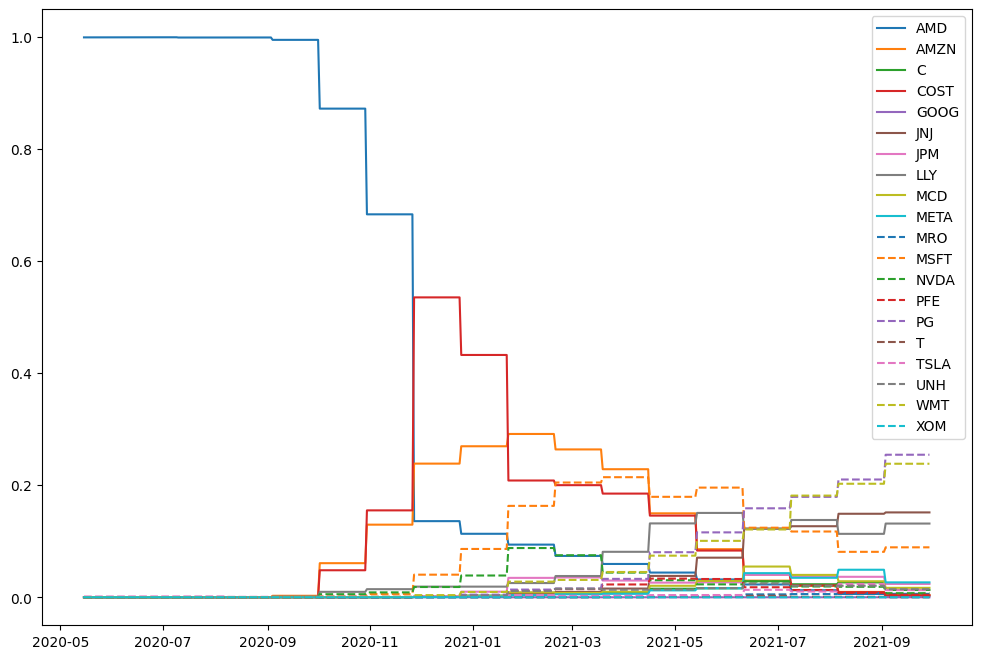

In [20]:
# Plot the portfolio weight allocation during the validation period.
plt.figure(figsize = (12,8))
for i in range(n_assets):
  if i < n_assets/2:
    ls = '-'
  else:
    ls = '--'
  plt.plot(val_timestamps,weights[:,i],label=asset_names[i], ls = ls)

plt.legend()

In [21]:
# Do the portfolio return calculation (as before) for the test period.

myModel = myModel.eval()

# Get X,Y features and timestamps for the test dataset.
X = torch.empty(0)
Y = torch.empty(0)
test_timestamps = []
for i in range(indices_test[0], indices_test[-1]+1):
  X_sample, Y_sample, timestamps_sample, _ = dataset.__getitem__(i)
  X = torch.cat((X,X_sample.unsqueeze(0)), dim = 0)
  Y = torch.cat((Y,Y_sample.unsqueeze(0)), dim = 0)
  test_timestamps.append(timestamps_sample)
X = X.float()

# Get the daily returns using Y.
rets = Y[:,0,0,:] + 1

# Calculate the weight allocations by inputting X to the model.
with torch.no_grad():
  weights = duplicate_rows(myModel(X),gap+horizon, is_val=False)
weights.shape

# Obtain weights for equal hold portfolio.
n_eq_weights = torch.ones([len(indices_test),n_assets])/n_assets
n_eq_weights.shape

# Obtain weights for the one-asset portfolios. We used TSLA and NVDA as they are the top performers during test period.
TSLA_weights = torch.zeros([len(indices_test),n_assets])
TSLA_weights[:,asset_names.index('TSLA')] = 1 # 16

NVDA_weights = torch.zeros([len(indices_test),n_assets])
NVDA_weights[:,asset_names.index('NVDA')] = 1 # 12

# Change the dimensions of returns and weights so portfolio returns can be performed using matrix multiplication.
rets = rets.unsqueeze(1)

weights = weights.unsqueeze(2)
n_eq_weights = n_eq_weights.unsqueeze(2)
TSLA_weights = TSLA_weights.unsqueeze(2)
NVDA_weights = NVDA_weights.unsqueeze(2)

portfolio_return = torch.bmm(rets.double(), weights.double()).squeeze(1).squeeze(1)
n_eq_return = torch.bmm(rets.double(), n_eq_weights.double()).squeeze(1).squeeze(1)
TSLA_return = torch.bmm(rets.double(), TSLA_weights.double()).squeeze(1).squeeze(1)
NVDA_return = torch.bmm(rets.double(), NVDA_weights.double()).squeeze(1).squeeze(1)

portfolio_return = torch.cumprod(portfolio_return, dim=0)
n_eq_return = torch.cumprod(n_eq_return, dim=0)
TSLA_return = torch.cumprod(TSLA_return, dim=0)
NVDA_return = torch.cumprod(NVDA_return, dim=0)

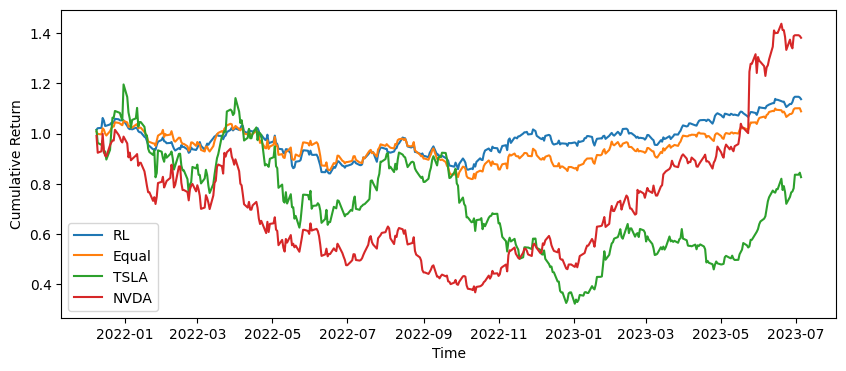

In [22]:
# Plot the portfolio cumulative return during validation period.
plt.figure(figsize=(10,4))

plt.plot(test_timestamps,portfolio_return, label = 'RL')
plt.plot(test_timestamps,n_eq_return, label = 'Equal')
plt.plot(test_timestamps,TSLA_return, label = 'TSLA')
plt.plot(test_timestamps,NVDA_return, label = 'NVDA')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Return')

plt.show()

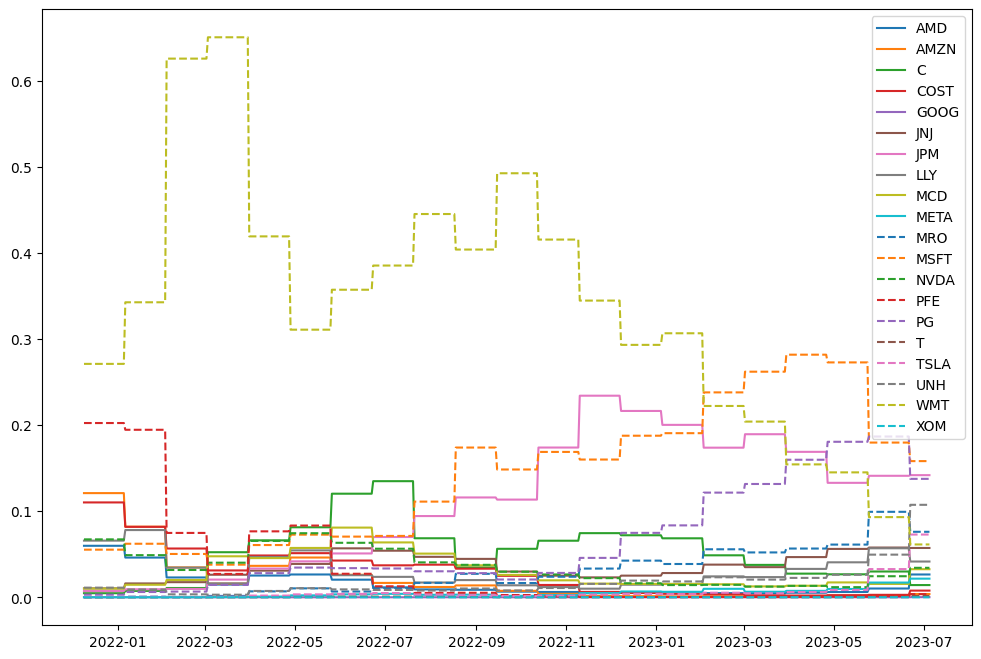

In [23]:
# Plot the portfolio weight allocation during the validation period.
plt.figure(figsize = (12,8))
for i in range(n_assets):
  if i < n_assets/2:
    ls = '-'
  else:
    ls = '--'
  plt.plot(test_timestamps,weights[:,i],label=asset_names[i], ls = ls)

plt.legend()